# Exercise 5

### Necessary imports

In [318]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk import pos_tag
import re
import string
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from gensim.models.ldamodel import LdaModel
from gensim.models import LsiModel
from gensim import corpora
from gensim.models import CoherenceModel
import warnings
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
warnings.filterwarnings("ignore")

stop_words = stopwords.words('english')
plt.style.use('dark_background')

### Dataset loading

In [319]:
df = pd.read_csv('data/reviews.csv', encoding='utf-8')
df.drop('Id', axis=1, inplace=True)
df = df.sample(n=1000, random_state=42)

### Pre-processing of dataset

In [320]:
lemmatizer = WordNetLemmatizer()

def preprocess(sentence):
    # Maintain only content words (nouns, verbs, adjectives, adverbs) of the sentence
    sentence = pos_tag(sentence.split())
    sentence = [word for word, tag in sentence if tag.startswith('NN')]
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('mail', '')
    sentence = sentence.replace('urllink', '')
    sentence = sentence.replace('nbsp', '')
    sentence = sentence.replace('link', '')
    sentence = sentence.replace('url', '')

    # Removing unwanted characters
    sentence = re.sub('[^A-Za-z0-9 ]+', " ", sentence)

    # Removing whitespaces
    sentence = sentence.strip()

    # Replacing more than 1 spaces with single space
    sentence = sentence.replace(r"\s\s+", " ")
    
    # Removing HTML tags
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)

    # Removing punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    # Removing numbers
    sentence = re.sub(r'\d+', '', sentence)

    # Removing stop words
    words = [lemmatizer.lemmatize(word) for word in sentence.split() if word not in stop_words]

    # Remove words with length less than 3
    words = [word for word in words if len(word) > 3]
    return ' '.join(words)

In [321]:
df['text_cleaned'] = df['Text'].apply(preprocess)

## First Method: LDA for topic modeling

In [322]:
# Tokenize the text with NLTK
texts = df['text_cleaned'].str.split()
# Create Dictionary
id2word = corpora.Dictionary(texts)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=10,
                     random_state=42,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='symmetric',
                     per_word_topics=True,
                     eta = 0.6)

In [323]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.209445  0.004057       1        1  56.878060
7     -0.023339  0.092709       2        1   9.589004
1     -0.007596 -0.062478       3        1   8.475476
9     -0.013737 -0.006032       4        1   6.520073
4     -0.031909 -0.005573       5        1   3.590178
0     -0.032625 -0.003498       6        1   3.540314
2     -0.029627 -0.005068       7        1   3.458072
6     -0.027435 -0.003561       8        1   3.311595
5     -0.020180 -0.009203       9        1   3.198197
8     -0.022996 -0.001353      10        1   1.439030, topic_info=           Term        Freq       Total Category  logprob  loglift
127      coffee  112.000000  112.000000  Default  30.0000  30.0000
117        food  136.000000  136.000000  Default  29.0000  29.0000
19        treat   56.000000   56.000000  Default  28.0000  28.0000
49      product  261.000000  261.000000  Default  27.0000  27.0000
10        taste  210.000000  210.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
772       thank    0.482831   12.017324  Topic10  -6.1706   1.0268
3211      match    0.284132    3.706065  Topic10  -6.7008   1.6729
995   afternoon    0.265124    3.293222  Topic10  -6.7701   1.7218
302       every    0.265122    4.658051  Topic10  -6.7701   1.3750
910        look    0.265123    5.834117  Topic10  -6.7701   1.1499

[440 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3157      1  0.453118  abundance
3158      1  0.453118   abundant
1915      1  0.264997       acid
1915      7  0.264997       acid
2105      1  0.307893   actually
...     ...       ...        ...
331       9  0.085649      yummy
582       1  0.189751      zevia
582       4  0.569253      zevia
3218      1  0.269807       zone
3218      4  0.539614       zone

[777 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 2, 10, 5, 1, 3, 7, 6, 9])

### Hyperparameter tuning

In [324]:
def calculate_coherence_score_lda(n):
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n, random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# List containing various hyperparameters
no_of_topics = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

best_coherence_score = 0
best_n = 0

for n in no_of_topics:
    coherence_score = calculate_coherence_score_lda(n)
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_n = n
print(f"Best Number of Topics: {best_n}")
print(f"Best Coherence Score: {best_coherence_score}")

Best Number of Topics: 7
Best Coherence Score: 0.30135100653418617


### Visualizing the topics with pyLDAvis

In [325]:
# Best model
best_lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=best_n,
                     random_state=42)
                        

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.014779  0.004137       1        1  17.331291
6     -0.089946 -0.009834       2        1  16.345158
0      0.020600 -0.093437       3        1  16.318983
5     -0.004960 -0.004072       4        1  14.961351
2      0.019428  0.000558       5        1  14.502699
1      0.082023  0.024789       6        1  11.700068
4     -0.012367  0.077859       7        1   8.840451, topic_info=         Term        Freq       Total Category  logprob  loglift
127    coffee  223.000000  223.000000  Default  30.0000  30.0000
117      food  207.000000  207.000000  Default  29.0000  29.0000
81     amazon  144.000000  144.000000  Default  28.0000  28.0000
10      taste  222.000000  222.000000  Default  27.0000  27.0000
422      bean   45.000000   45.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
89   shipping    4.526546   34.583679   Topic7  -5.7479   0.3924
624   vanilla    4.101820   24.534383   Topic7  -5.8465   0.6372
87      order    4.774983   77.476814   Topic7  -5.6945  -0.3608
77      water    4.563011   79.214527   Topic7  -5.7399  -0.4283
146   quality    4.270280   57.207913   Topic7  -5.8062  -0.1692

[535 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
680       2  0.772949      account
1625      5  0.812565     activity
2105      4  0.327078     actually
2105      7  0.654156     actually
2534      6  0.792637  advertising
...     ...       ...          ...
2323      2  0.236214         zero
2323      6  0.708643         zero
1367      1  0.817390       zinger
2204      5  0.609798     ziwipeak
3218      4  0.812589         zone

[1177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 1, 6, 3, 2, 5])

### Create Cloud Words for each topic

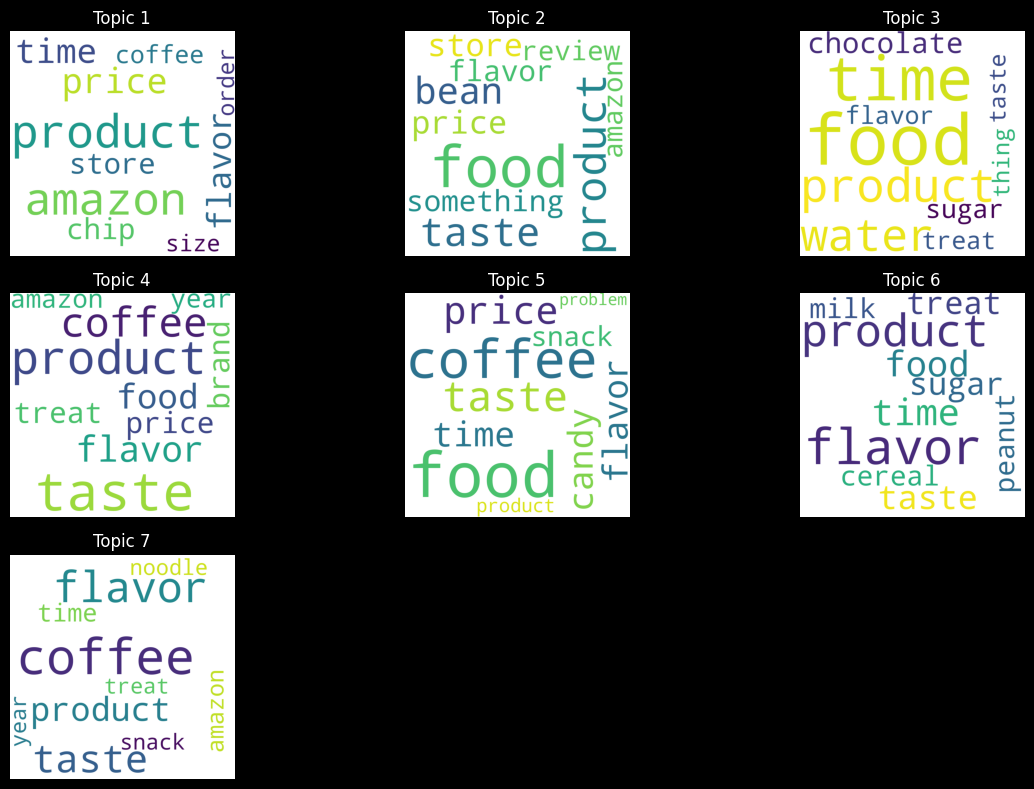

In [326]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

for i in range(best_n):
    words = best_lda_model.show_topics()[i][1].split('+')
    top_terms_key = {}
    for term in words:
        word = term.split('*')[1].replace('"', '')
        freq = term.split('*')[0]
        top_terms_key[word] = float(freq)
    wc = WordCloud(background_color="white",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(top_terms_key)
    plt.subplot(int(best_n / 2), int(best_n / 2), i+1)
    plt.title(f"Topic {i+1}")
    plt.axis('off')
    plt.imshow(wc)

## Second Method: LSA for topic modeling

### Creating the corpus and dictionary

In [327]:
# Tokenize the text with NLTK
texts = df['text_cleaned'].str.split()

# Create Dictionary
id2word = corpora.Dictionary(texts)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in texts]

### Hyperparameter tuning for LSA

In [328]:
def calculate_coherence_score_lsi(n):
    lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=n, random_seed=42)
    coherence_model_lsi = CoherenceModel(model=lsi_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lsi = coherence_model_lsi.get_coherence()
    return coherence_lsi

# List containing various hyperparameters
no_of_topics = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

best_coherence_score = 0
best_n = 0

for n in no_of_topics:
    coherence_score = calculate_coherence_score_lsi(n)
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_n = n
print(f"Best Number of Topics: {best_n}")
print(f"Best Coherence Score: {best_coherence_score}")

Best Number of Topics: 11
Best Coherence Score: 0.4247282728914602


### Creating the WordClouds for each topic

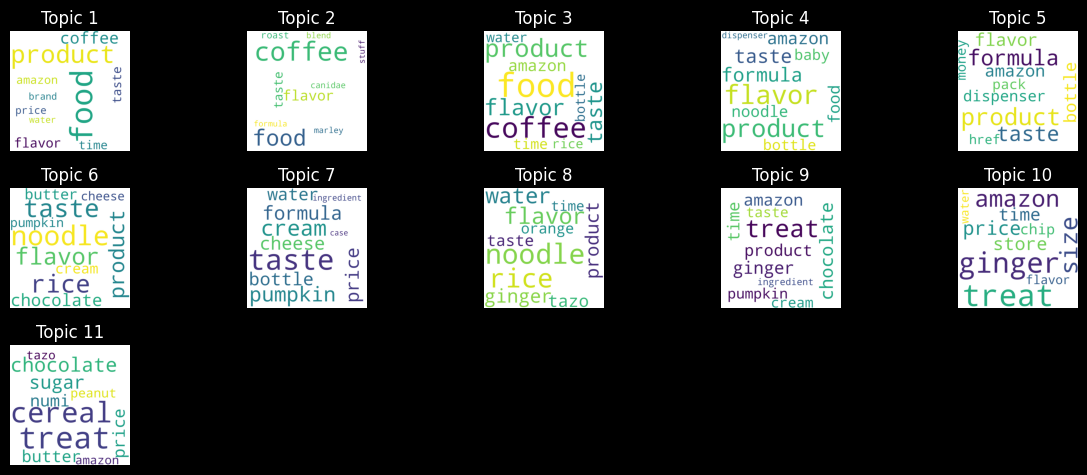

In [329]:
import numpy as np

best_lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=best_n, random_seed=42)

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

for i in range(best_n):
    words = best_lsi_model.show_topics()[i][1].split('+')
    top_terms_key = {}
    for term in words:
        word = term.split('*')[1].replace('"', '')
        freq = abs(float(term.split('*')[0]))
        top_terms_key[word] = float(freq)

    norm_1 = np.abs([val for val in top_terms_key.values()]).sum(axis=0)
    normalized_top_terms_key = {key:top_terms_key[key]/norm_1 for key in top_terms_key.keys()}
    
    wc = WordCloud(background_color="white",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(normalized_top_terms_key)
    plt.subplot(int(best_n / 2), int(best_n / 2), i+1)
    plt.title(f"Topic {i+1}")
    plt.axis('off')
    plt.imshow(wc)